## Assignment 8

In [1]:
!git clone https://github.com/scarecrow-tsai/eva6-assignment-8
%cd eva6-assignment-8/

!pip install -U albumentations

fatal: destination path 'eva6-assignment-8' already exists and is not an empty directory.
/content/eva6-assignment-8
Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (1.0.0)


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from albumentations.pytorch import ToTensorV2

from app.models.resnet import ResNet
from app.utils.transforms import transforms
from app.datasets.cifar10 import load_cifar10
from app.explainability.gradcam import GradCAM
from app.utils.misc import set_seed, tensor_to_image
from app.utils.train_test_loops import train_loop, test_loop
from app.utils.result_stats import loss_acc_curves, score_report
from app.utils.result_analysis import (
    get_misclassified_info,
    visualize_misclassified_images,
    misclassified_gradcam
)
from app.utils.dataset import (
    calc_data_stats,
    visualise_transforms,
    class_to_idx,
    idx_to_class,
)

import matplotlib.pyplot as plt

set_seed(69)

In [5]:
################################
## CONFIG
################################


DATASET_NAME = "cifar10"
DATASET_PATH = f"./../data/{DATASET_NAME}/"
NUM_CLASSES = 10
NUM_INPUT_CHANNELS = 3


BATCH_SIZE = 256
EPOCHS = 20
LEARNING_RATE = 0.01


# SET GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nWe're using =>", device)


We're using => cuda


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

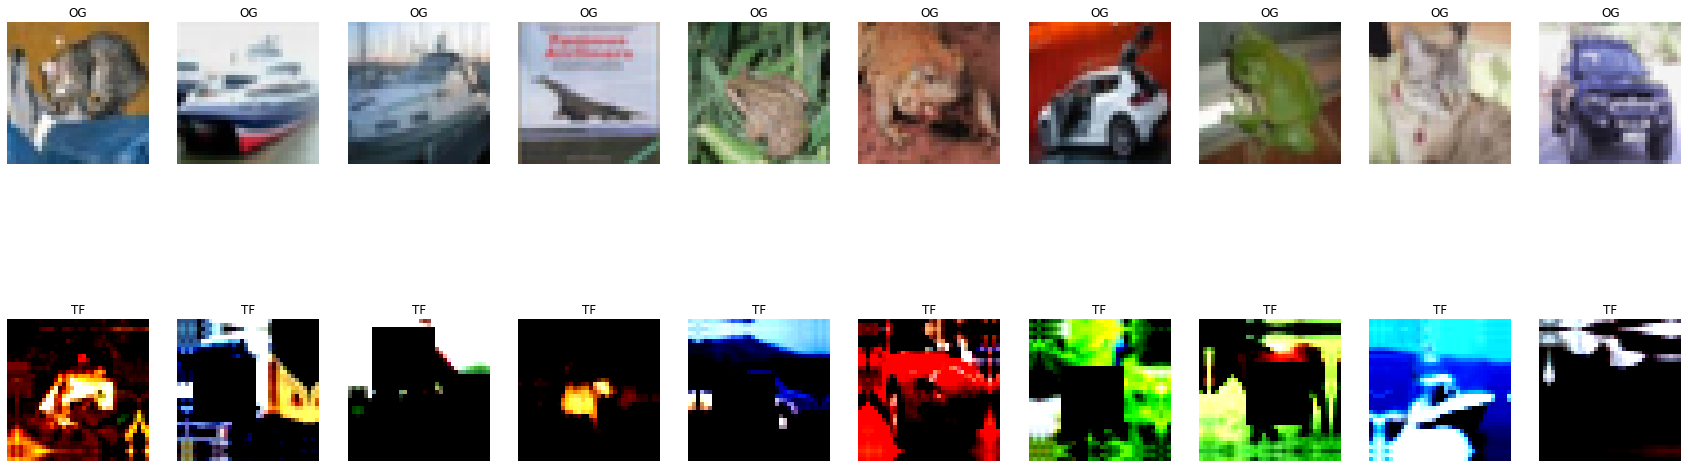

In [6]:
################################
## LOAD DATASET
################################

# datasets
og_dataset = load_cifar10(
    dataset_path=DATASET_PATH, is_train=False, image_transforms=ToTensorV2(),
)

# calculate dataset mean and std
dataset_mean, dataset_std = calc_data_stats(og_dataset)

image_transforms = transforms(dataset_mean, dataset_std)

train_dataset = load_cifar10(
    dataset_path=DATASET_PATH,
    is_train=True,
    image_transforms=image_transforms["train"],
)

test_dataset = load_cifar10(
    dataset_path=DATASET_PATH,
    is_train=False,
    image_transforms=image_transforms["test"],
)


class2idx = class_to_idx(og_dataset.classes)
idx2class = idx_to_class(class2idx)


visualise_transforms(
    original_data=og_dataset, transformed_data=train_dataset, num_samples=10
)

In [7]:
################################
## CREATE DATALOADERS
################################

# dataloader
train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=BATCH_SIZE)

val_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=BATCH_SIZE)

test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=BATCH_SIZE)

## Data Sanity Check
print(f"\nTrain loader = {next(iter(train_loader))[0].shape}")
print(f"Val loader = {next(iter(val_loader))[0].shape}")
print(f"Test loader = {next(iter(test_loader))[0].shape}")
print(f"\nTrain loader length = {len(train_loader)}")
print(f"Val loader length = {len(val_loader)}")
print(f"Test loader length = {len(test_loader)}")


Train loader = torch.Size([256, 3, 36, 36])
Val loader = torch.Size([256, 3, 36, 36])
Test loader = torch.Size([256, 3, 32, 32])

Train loader length = 196
Val loader length = 196
Test loader length = 40


In [8]:
################################
## LOAD MODEL
################################

model = ResNet(num_input_channels=NUM_INPUT_CHANNELS, num_classes=NUM_CLASSES)

x_train_example, y_train_example = next(iter(train_loader))
y_pred_example = model(x_train_example)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.99)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 1)


Begin training.


Epoch 01/20: | Train Loss: 1.69873 | Val Loss: 1.52751 | Train Acc: 37.684% | Val Acc: 44.541%
Epoch 02/20: | Train Loss: 1.53169 | Val Loss: 1.40390 | Train Acc: 44.143% | Val Acc: 49.128%
Epoch 03/20: | Train Loss: 1.44238 | Val Loss: 1.32257 | Train Acc: 47.770% | Val Acc: 52.031%
Epoch 04/20: | Train Loss: 1.35341 | Val Loss: 1.24652 | Train Acc: 50.893% | Val Acc: 55.158%
Epoch 05/20: | Train Loss: 1.33961 | Val Loss: 1.21698 | Train Acc: 51.990% | Val Acc: 56.658%
Epoch 06/20: | Train Loss: 1.25307 | Val Loss: 1.14849 | Train Acc: 54.862% | Val Acc: 58.872%
Epoch 07/20: | Train Loss: 1.16745 | Val Loss: 1.08474 | Train Acc: 57.821% | Val Acc: 61.301%
Epoch 08/20: | Train Loss: 1.11115 | Val Loss: 1.02930 | Train Acc: 59.980% | Val Acc: 63.459%
Epoch 09/20: | Train Loss: 1.08539 | Val Loss: 0.99907 | Train Acc: 61.240% | Val Acc: 64.480%
Epoch 10/20: | Train Loss: 1.05454 | Val Loss: 0.97323 | Train Acc: 62.250% | Val Acc: 65.372%
Epoch 11/20: | Train Loss: 1.01633 | Val Loss: 0.9

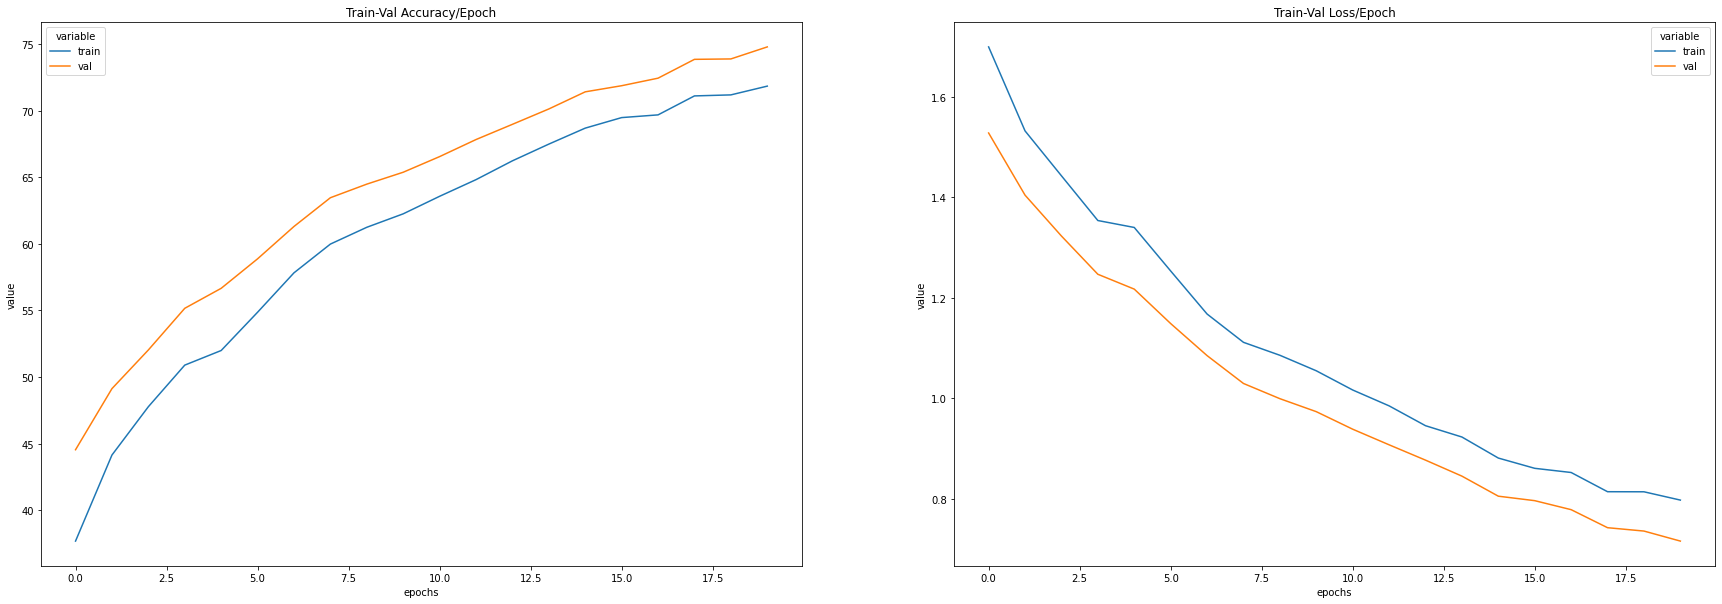

In [9]:
################################
## Train Loop
################################
trained_model, loss_stats, acc_stats = train_loop(
    model=model,
    epochs=EPOCHS,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
)


loss_acc_curves(loss_stats=loss_stats, acc_stats=acc_stats)

In [10]:
################################
## Test Loop
################################
y_pred_list, y_true_list = test_loop(
    model=trained_model, test_loader=test_loader, device=device,
)

Test Accuracy = 0.7329


Classification Report: 

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      1000
           1       0.91      0.83      0.87      1000
           2       0.55      0.66      0.60      1000
           3       0.57      0.54      0.56      1000
           4       0.67      0.75      0.71      1000
           5       0.68      0.59      0.63      1000
           6       0.76      0.79      0.77      1000
           7       0.83      0.72      0.77      1000
           8       0.84      0.86      0.85      1000
           9       0.92      0.78      0.85      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000




Confusion Matrix: 

[[803   9  89   9  20   3   2   6  56   3]
 [ 54 828   8   7   3   2   5   3  46  44]
 [ 67   1 662  39  92  55  66  13   3   2]
 [ 26   2 112 540  61 131  85  29  12  

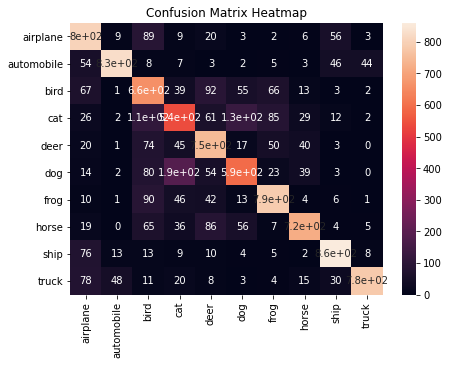

In [11]:
################################
## Result Stats
################################
print(score_report(y_true_list, y_pred_list, idx2class))

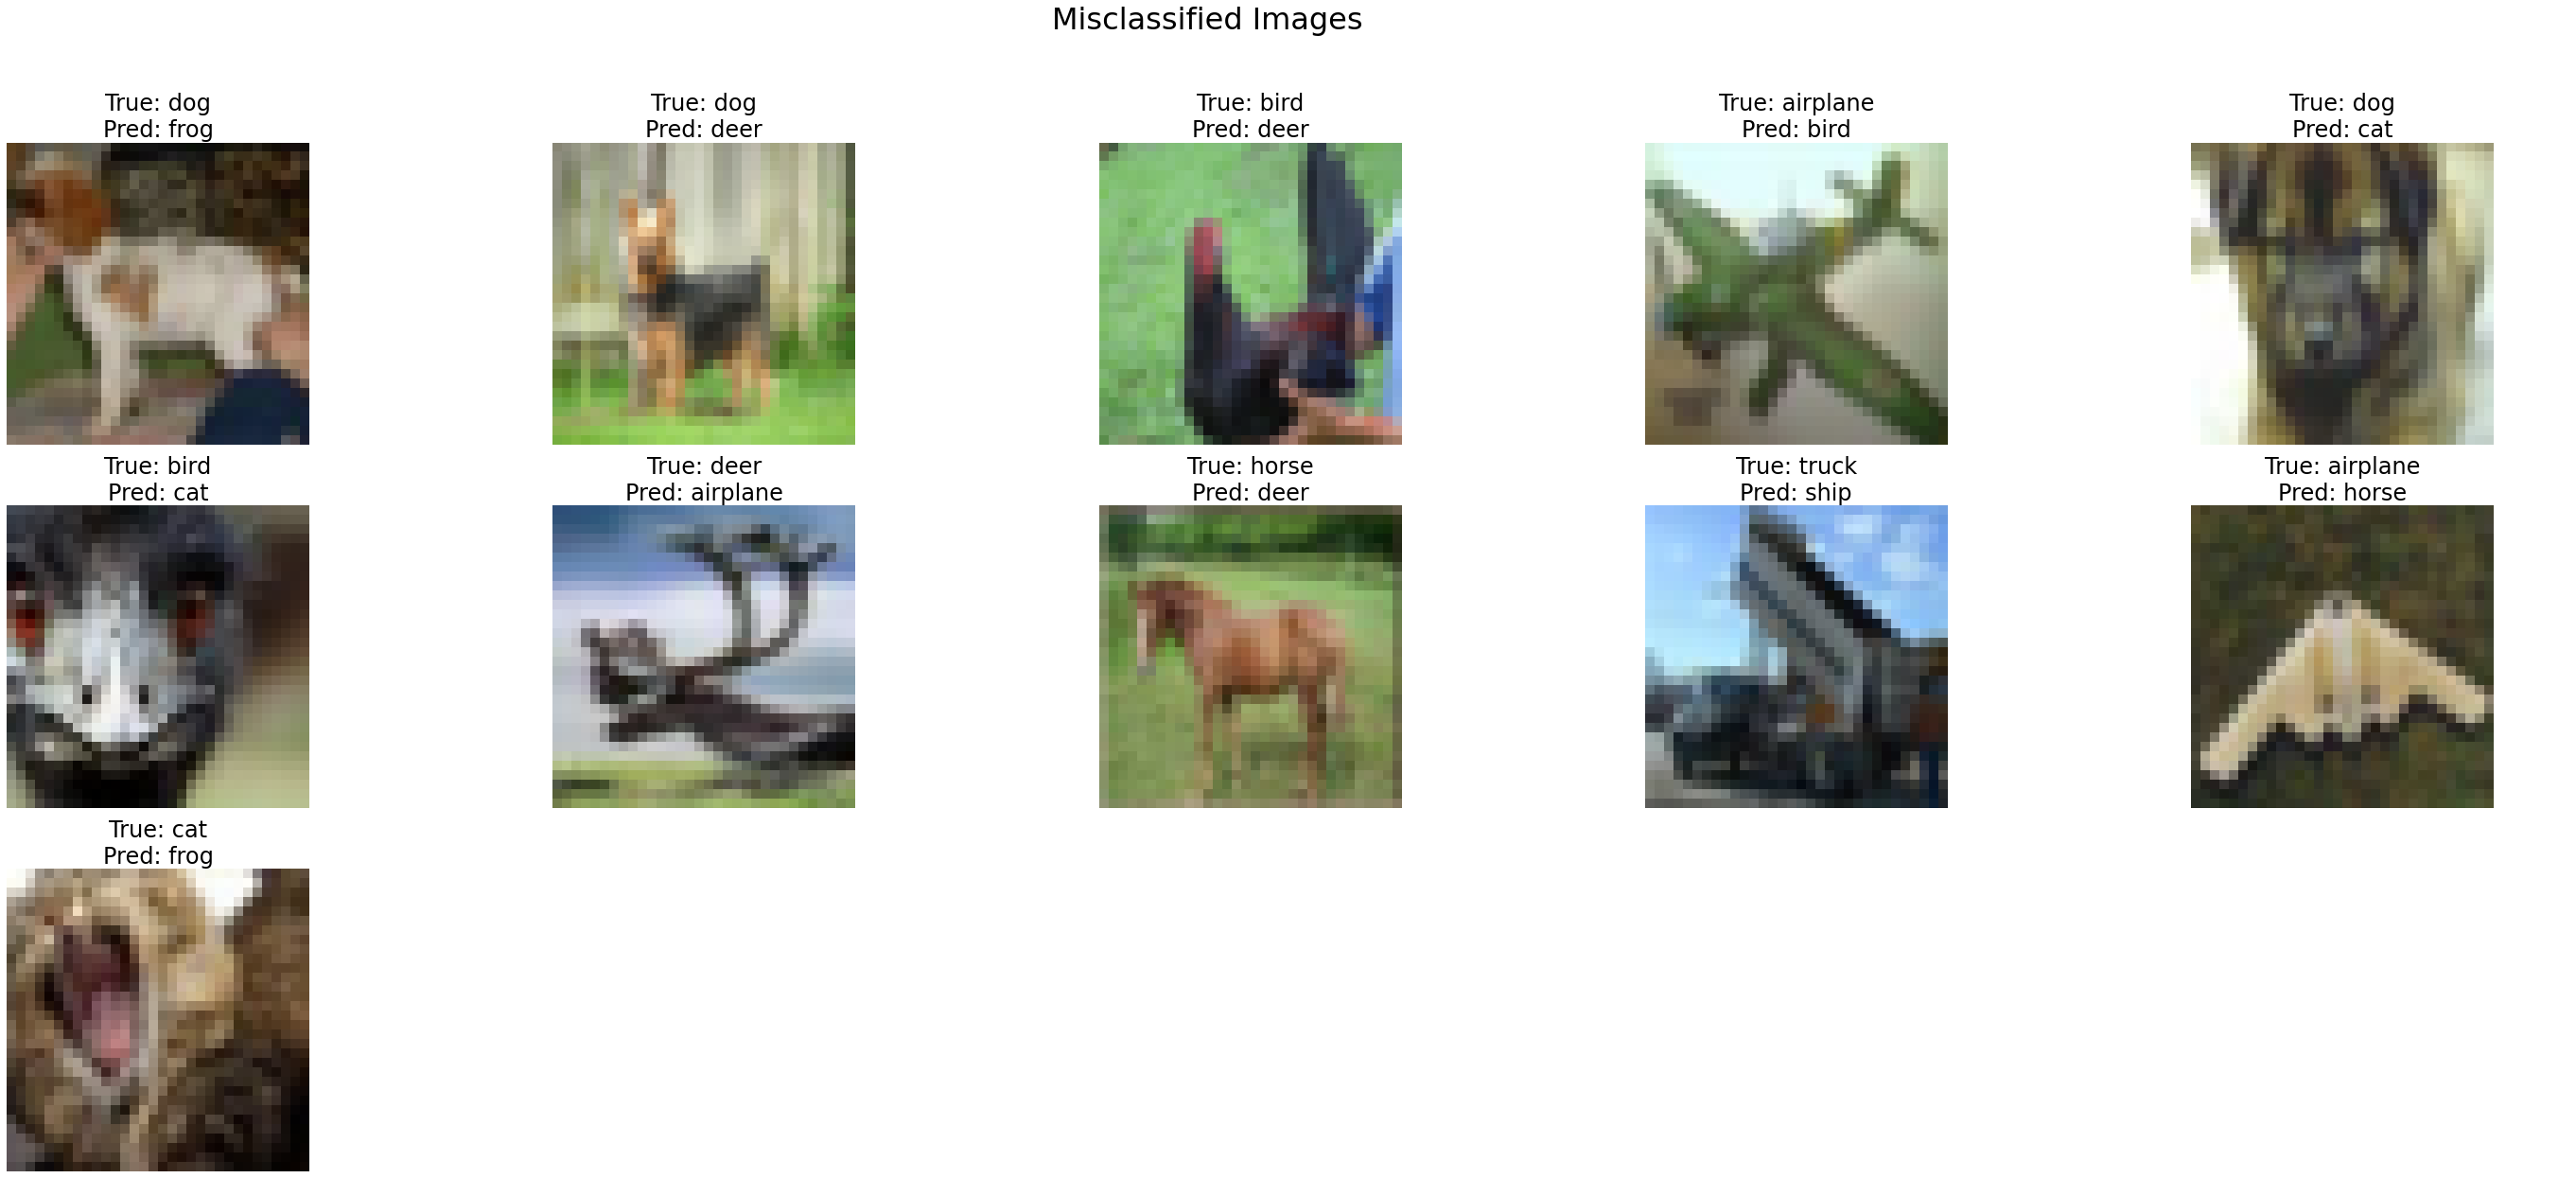

In [12]:
################################
## Result Analysis
################################

def get_misclassified_info(y_pred_list, y_true_list):
    return [
        {"idx": i, "pred": pred, "true": actual}
        for i, (pred, actual) in enumerate(zip(y_pred_list, y_true_list))
        if pred != actual
    ]


misclassified_info = get_misclassified_info(
    y_pred_list=y_pred_list, y_true_list=y_true_list
)


visualize_misclassified_images(
    misclassified_info=misclassified_info,
    dataset=og_dataset,
    idx_to_class=idx2class,
    num_samples=11,
)

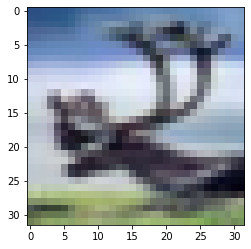

In [13]:
################################
## GradCAM
################################
x_test, y_test = test_dataset[40]


tensor_to_image(x_test)

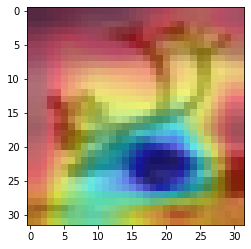

In [14]:
cam = GradCAM(
    model=trained_model, target_layer=trained_model.layer_2.base_layer[-1].base_block[-1][0]
)

output = cam(x_test.to(device))


plt.imshow(output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

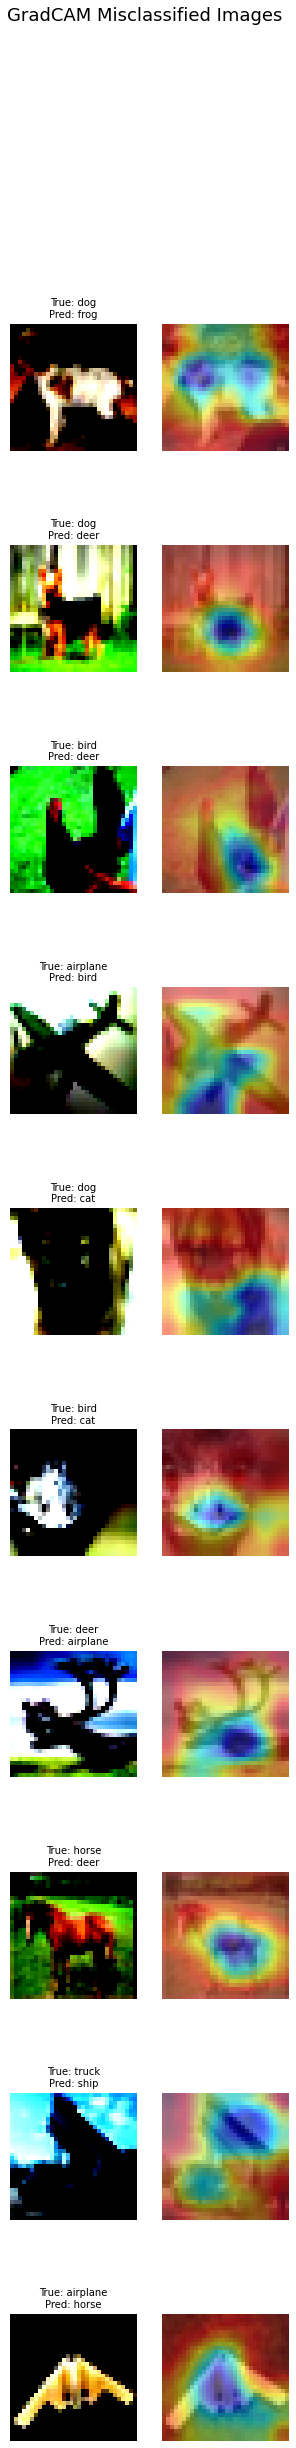

In [15]:
misclassified_gradcam(
    model = trained_model,
    misclassified_info=misclassified_info,
    dataset=test_dataset,
    idx_to_class=idx2class,
    num_samples=10,
    device=device
)